In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback
import random
import os

import tensorflow as tf
print(tf.__version__)

import matplotlib.pyplot as plt
%matplotlib inline

2.6.0


In [2]:

filename = "poem.txt"
raw_text = open(filename, 'r', encoding='utf-8').read()
raw_text = raw_text.lower()

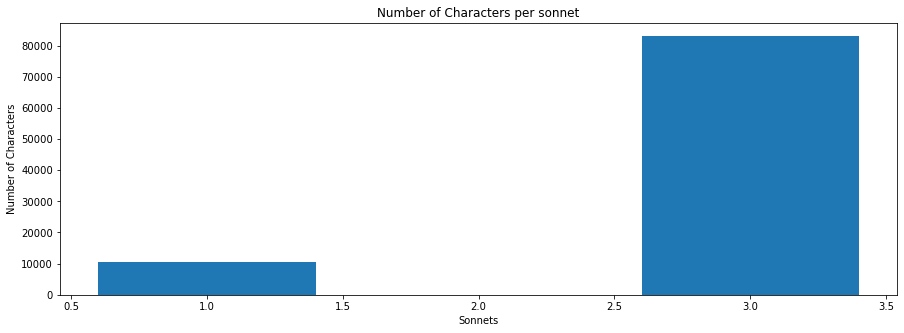

Maximum sonnet length: 83099.00 characters
Minimum sonnet length: 6.00 characters
Average sonnet length: 31191.00 characters


In [3]:
sonnets = raw_text.split('\n\n')
sonnet_lens = [len(sonnet) for sonnet in sonnets]

plt.figure(figsize=(15, 5))
plt.bar([i for i in range(1, len(sonnets)+1)], sonnet_lens)
plt.title('Number of Characters per sonnet')
plt.ylabel('Number of Characters')
plt.xlabel('Sonnets')
plt.show()


print('Maximum sonnet length: %.2f characters' % np.max(sonnet_lens))
print('Minimum sonnet length: %.2f characters' % np.min(sonnet_lens))
print('Average sonnet length: %.2f characters' % np.mean(sonnet_lens))

In [4]:

# create mapping of unique characters to integers and integers to unique characters
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

In [5]:
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  93577
Total Vocab:  36


In [6]:
# cut the text in semi-redundant sequences of maxlen (40) characters

maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(raw_text) - maxlen, step):
    sentences.append(raw_text[i: i + maxlen])
    next_chars.append(raw_text[i + maxlen])
print('number of sequences:', len(sentences))

number of sequences: 31179


In [7]:
# Vectorization

x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_to_int[char]] = 1
    y[i, char_to_int[next_chars[i]]] = 1

In [8]:
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               84480     
_________________________________________________________________
dense (Dense)                (None, 36)                4644      
Total params: 89,124
Trainable params: 89,124
Non-trainable params: 0
_________________________________________________________________


In [9]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [10]:
class myCallback(Callback):


  def on_epoch_end(self, epoch, logs={}):
      # Function invoked at end of each epoch. Prints generated text.
      print('')
      base_dir = 'generated_text'
      if not os.path.isdir(base_dir):
          os.mkdir(base_dir)
      
      epoch_dir = os.path.join(base_dir, 'epoch_' + str(epoch))
      if not os.path.isdir(epoch_dir):
          os.mkdir(epoch_dir)

      start_index = random.randint(0, len(raw_text) - maxlen - 1)
      for diversity in [0.2, 0.5, 1.0, 1.2]:
        
          diversity_file = 'epoch' + str(epoch) + '_diversity=' + str(diversity) + '.txt'
          file = open(os.path.join(epoch_dir, diversity_file), 'w')

          generated = ''
          sentence = raw_text[start_index: start_index + maxlen]
          generated += sentence
          
          file.write(generated)

          for i in range(600):
              x_pred = np.zeros((1, maxlen, len(chars)))
              for t, char in enumerate(sentence):
                  x_pred[0, t, char_to_int[char]] = 1.

              preds = model.predict(x_pred, verbose=0)[0]
              next_index = sample(preds, diversity)
              next_char = int_to_char[next_index]

              sentence = sentence[1:] + next_char

              file.write(next_char)
        
          print('diversity ' + str(diversity) + " done.")
          file.close()

In [11]:
# define the checkpoint
directory = 'model'
if not os.path.isdir(directory):
    os.mkdir(directory)
%cd model
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss')
callback = [checkpoint, myCallback()]

C:\Users\soumya.sinha\model


In [12]:
history = model.fit(x, y,
          batch_size=128,
          epochs=60,
          callbacks=callback)

Epoch 1/60
244/244 [==============================] - 18s 69ms/step - loss: 2.4100

diversity 0.2 done.
diversity 0.5 done.
diversity 1.0 done.
diversity 1.2 done.
Epoch 2/60
244/244 [==============================] - 18s 74ms/step - loss: 1.9472

diversity 0.2 done.
diversity 0.5 done.
diversity 1.0 done.
diversity 1.2 done.
Epoch 3/60
244/244 [==============================] - 14s 57ms/step - loss: 1.7723

diversity 0.2 done.
diversity 0.5 done.
diversity 1.0 done.
diversity 1.2 done.
Epoch 4/60
244/244 [==============================] - 14s 57ms/step - loss: 1.6450

diversity 0.2 done.
diversity 0.5 done.
diversity 1.0 done.
diversity 1.2 done.
Epoch 5/60
244/244 [==============================] - 15s 60ms/step - loss: 1.5477

diversity 0.2 done.
diversity 0.5 done.
diversity 1.0 done.
diversity 1.2 done.
Epoch 6/60
244/244 [==============================] - 13s 55ms/step - loss: 1.4549

diversity 0.2 done.
diversity 0.5 done.
diversity 1.0 done.
diversity 1.2 done.
Epoch 7/60
244/2

In [13]:
def generate_sonnet(temp):
    ''' Given a temperature, generate a new sonnet '''
    start_idx = np.random.randint(0, len(raw_text) - maxlen - 1)
    new_sonnet = raw_text[start_idx:start_idx + maxlen]
    print(new_sonnet)
    for i in range(600):
        # Vectorize generated text
        sampled = np.zeros((1, maxlen, len(chars)))
        for j, char in enumerate(new_sonnet):
            sampled[0, j, char_to_int[char]] = 1.

        # Predict next character
        preds = model.predict(sampled, verbose=0)[0]
        pred_idx = sample(preds, temperature=temp)
        next_char = chars[pred_idx]

        # Append predicted character to seed text
        new_sonnet += next_char
        new_sonnet = new_sonnet[1:]

        # Print to console
        print(next_char, end = '')

In [14]:
generate_sonnet(0.2)

writ,
not making worse what nature made 
was pride.
o, bears of their swory show whos the wronge?
bow sweet best arturd to granes of such sees'
cruel i take thoughts in the edsifter.
that healthf of worthy shall i be which desert,
for i in my love sweet berow whose done;
but thou to the ehsseep, a stay, and i rest;
but they love say thou sear of youthie pended
thy forcor all i pride thee hat so will is due,
but i so seet, stand os the winy beauty'st thee:
when i dot false world deep in
the world with thing; i not to thee that well such send,
tires of their for what they rettant shall i despay
and praises of their ride impence to thee

In [15]:
generate_sonnet(0.5)

ers to outlive long date.
if my slight m
y posir on the forsert of thy face:
so to beaster's seem whose dare freion.
love resare far for my despave make was summer's dief
thy sake have proud cheek shall ruimies ante.
thou seasing of their eart in her face.
but no doing eyes are not thy disping sweet,
which work the eash from how leppiss,
with for thy dost to praise will king,
or have's foo, and sho stall all weree?
whook, whose fall's the world with thing.
o, whose thoughts thee to see 'tilt to me.
then the etress's dul purect of their ride
which altern is 'finge to prove to eyes bessoold.
but thy doth havion'd i farsed than the eyes

In [16]:
generate_sonnet(1.0)

thee, my loss is my love's gain,
and los
t all were where is the mother 'sade
and take a 'tis and thou wearth they sand,
or my groald'd, of hast thy love's ownwhness;
and your your was i seem resir'd tring,
and sink king anspiet death her worthy shame;
both rost thou sear to great which chark
caruth of griend a deadery, but not with new-c
upliving,y and bose health, that is need mine,
nor imblack bain lesse, surver muse unviled
for him when i say, my love's sowler pain;
how the world when thou rost have but your still.
look's more from the rost far for my sake?
yet all my lime hast thou dost subtr, your crunted, respoon scy live ?
o,

In [17]:
generate_sonnet(1.2)

they see aright?
if that be fair whereon
 you wilts of hist,
and'd the dumbles makeed had gentle by mist:
bain the filgs when i rea, sifpentlest wiy
no ngriles so groat;
for you wourd crunt otrught i make when show,
the other of this fongsed, and go me, in more
that etsift doth file his gaidsten thou ded,
and who it thy phosouths best best sins,
when i for my despive might if their restife.
th.
roses, in lost in love,
and do not may out hold heart awree of loombrevall'
love whithing of belf-al, decenvented,
unthy lidies report, trom may chiod;
but then i do baindning and ensure might imblyst
b:
what confort mine own well by ever ther